### Step - 0 Import libraries

In [1]:
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
import numpy as np
from copy import deepcopy
import copy 
from utils import action_value_plot, test_agent
from typing import Any, Tuple, Dict, Optional

### Step - 1 Define Grid World Environment class

In [2]:
def clamp(v, minimal_value, maximal_value):
    return min(max(v, minimal_value), maximal_value)

class GridWorldEnv(gym.Env):
    def __init__(self, map_name="standard"):
        if map_name == "standard":
            self.map = [
                list("s   "),
                list("    "),
                list("    "),
                list("gt g"),
            ]
            self.action_space = spaces.Discrete(4)
            self.observation_space = spaces.Box(low = 0, high = 4, shape = (2,), dtype = np.int32)
            self.start_position = [0, 0]
            self.agent_position = None
            self.trap_reward , self.step_reward = -1.0, 0.0
        elif map_name == "clifwalk":
            self.map = [
                list("s   "),
                list("    "),
                list("    "),
                list("gt g"),
            ]
            self.action_space = spaces.Discrete(4)
            self.observation_space = spaces.Box(low=0, high=4, shape=(2,), dtype = np.int32)
            self.start_position=[0,0]
            self.agent_position = None
            self.trap_reward, self.step_reward = -1.0, -0.005
    
    def reset(self,
              *,
              seed: Optional[int] = None,
              options: Optional[dict] = None,):
        self.agent_position = deepcopy(self.start_position)
        return self._observe(),{}
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        assert self.action_space.contains(action)
        match action:
            case 0:  # up
                self.agent_position[0] -= 1
            case 1:  # right
                self.agent_position[1] += 1
            case 2:  # down
                self.agent_position[0] += 1
            case _:  # left
                self.agent_position[1] -= 1

        self.agent_position[0] = clamp(self.agent_position[0], 0, 3)
        self.agent_position[1] = clamp(self.agent_position[1], 0, 3)
        observation = self._observe()
        reward, done = self.step_reward, False
        if 't' == self.map[self.agent_position[0]][self.agent_position[1]]:
            reward, done = self.trap_reward, True
        if 'g' == self.map[self.agent_position[0]][self.agent_position[1]]:
            reward, done = +1, True
        return observation, reward, done, False, {}

    def render(self):
        rendered_map = copy.deepcopy(self.map)
        rendered_map[self.agent_position[0]][self.agent_position[1]] = "A"
        print("--------")
        for row in rendered_map:
            print('|', end='')
            for cell in row:
                print("{}|".format(cell), end='')
            print()
        print("--------")
        return None

    def close(self):
        pass

    def _observe(self):
        return np.array(self.agent_position)

### Step - 2 Create Agents

#### Step - 2.1 Create Base Agent

In [3]:
import numpy as np 

class BaseAgent:
    def __init__(self, env, discount_factor, learning_rate, epsilon):
        self.env = env
        self.g = discount_factor
        self.lr = learning_rate
        self.eps = epsilon
        self.num_actions = env.action_space.n
        self.Q = np.zeros((*env.observation_space.high, self.num_actions), dtype=np.float32)
    
    def action(self, s, epsilon=None):
        eps = epsilon if epsilon is not None else self.eps

        if np.random.rand() < eps:
            return self.env.action_space.sample()
        else:
            y, x = s
            return np.argmax(self.Q[y, x])
    

#### Step 2.2 Create SARSA Agent

In [8]:
class SARSAAgent(BaseAgent):
    def __init__(self, env, discount_factor, learning_rate, epsilon):
        super(SARSAAgent, self).__init__(env, discount_factor, learning_rate, epsilon)

    def learn(self, n_timesteps=200000):
        s, _ = self.env.reset()
        a = self.action(s)  # Epsilon-greedy action for initial state

        for i in range(n_timesteps):
            # TODO 1.2: Implement SARSA training loop
            # You will have to call self.update_Q(...) at every step
            # Do not forget to reset the environment and update the action if you receive a 'terminated' signal
            s_, r, terminated, truncated, _ = self.env.step(a)
            a_ = self.action(s_)  # Epsilon-greedy action for next state
            self.update_Q(s, a, r, s_, a_)
            if terminated or truncated:
                s, _ = self.env.reset()
                a = self.action(s)  # Reset the action for the new episode
            else:
                s, a = s_, a_

    def update_Q(self, s, a, r, s_, a_):
        # TODO 1.2: Implement SARSA update
        self.Q[*s, a] = 0.0
        y, x = s
        y_, x_ = s_
        self.Q[y, x, a] += self.lr * (r + self.g * self.Q[y_, x_, a_] - self.Q[y, x, a])



#### Step - 2.3 Create QLearning Agent

In [5]:
class QLearningAgent(BaseAgent):
    def __init__(self, env, discount_factor, learning_rate, epsilon):
        super(QLearningAgent, self).__init__(env, discount_factor, learning_rate, epsilon)

    def learn(self, n_timesteps=200000):
        s, _ = self.env.reset()

        for i in range(n_timesteps):
            # TODO 1.3: Implement Q-learning training loop
            # You will have to call self.update_Q(...) at every step
            # Do not forget to reset the environment if you receive a 'terminated' signal
            a = self.action(s)
            s_, r, terminated, truncated, _ = self.env.step(a)
            self.update_Q(s, a, r, s_)

            if terminated or truncated:
                s, _ = self.env.reset()
            else:
                s=s_


    def update_Q(self, s, a, r, s_):
        # TODO 1.3: Implement Q-learning update
        y, x = s
        y_, x_ = s_ 
        max_Q_next = np.max(self.Q[y_, x_])
        self.Q[y, x, a] += self.lr*(r + self.g * max_Q_next - self.Q[y, x, a])


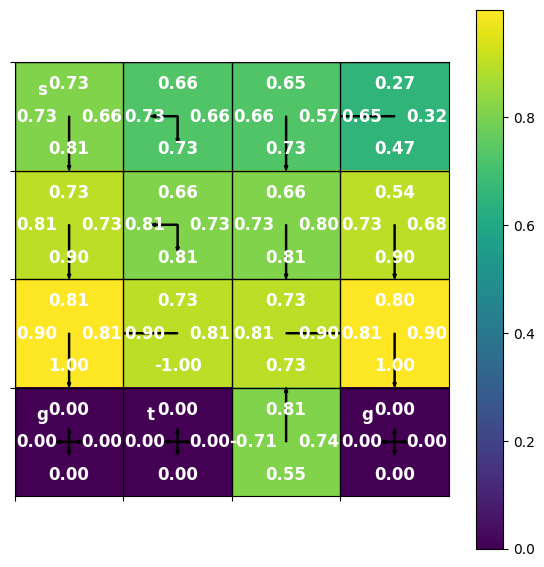

Testing Q-Learning agent
--------
|A| | | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
|A| | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
| |A| | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
| | | | |
| |A| | |
|g|t| |g|
--------
--------
|s| | | |
| | | | |
|A| | | |
|g|t| |g|
--------
--------
|s| | | |
|A| | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
| | | | |
|A| | | |
|g|t| |g|
--------
--------
|s| | | |
| | | | |
| | | | |
|A|t| |g|
--------


In [6]:
env = GridWorldEnv(map_name="standard")

agent = "qlearning"

if agent =="sarsa":  # Train SARSA agent
    sarsa_agent = SARSAAgent(env, 0.9, 0.05,0.4)
    sarsa_agent.learn(n_timesteps= 200000)
    action_value_plot(sarsa_agent)
    print('Testing SARSA agent')
    test_agent(sarsa_agent, env, epsilon=0.1)
elif agent == "qlearning":  # Train Q-learning agent
    qlearning_agent = QLearningAgent(env, 0.9, 0.05, 0.4)
    qlearning_agent.learn(n_timesteps=200000)
    action_value_plot(qlearning_agent)
    print('Testing Q-Learning agent')
    test_agent(qlearning_agent, env, epsilon=0.1)
else:
    raise NotImplementedError

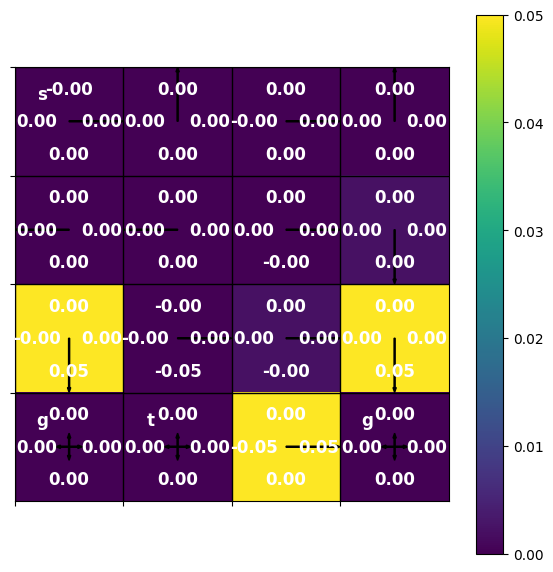

Testing SARSA agent
--------
|A| | | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s|A| | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s|A| | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s|A| | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s|A| | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s|A| | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s|A| | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s|A| | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s|A| | |
| | | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
| |A| | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
|A| | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
|A| | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
|A| | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
|A| | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
|A| | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
|A| | | |
| | | | |
|g|t| |g|
--------
--------
|s| | | |
|A| | | |
| | | | |
|g|t| |g|
---

In [9]:
env = GridWorldEnv(map_name="standard")

agent = "sarsa"

if agent =="sarsa":  # Train SARSA agent
    sarsa_agent = SARSAAgent(env, 0.9, 0.05,0.4)
    sarsa_agent.learn(n_timesteps= 200000)
    action_value_plot(sarsa_agent)
    print('Testing SARSA agent')
    test_agent(sarsa_agent, env, epsilon=0.1)
elif agent == "qlearning":  # Train Q-learning agent
    qlearning_agent = QLearningAgent(env, 0.9, 0.05, 0.4)
    qlearning_agent.learn(n_timesteps=200000)
    action_value_plot(qlearning_agent)
    print('Testing Q-Learning agent')
    test_agent(qlearning_agent, env, epsilon=0.1)
else:
    raise NotImplementedError